Requieres [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/)<br>
`pip install category_encoders`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
target_names = ['class 0', 'class 1']

In [2]:
#load dataset
df = pd.read_csv('capture20110816-3.binetflow.csv')

In [ ]:
#delete StartTime feature
df.drop(['StartTime'],axis=1,inplace=True)
#df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

In [3]:
#check dimensions
df.shape

(2954230, 15)

In [4]:
df.head(5)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/16 14:23:17.316620,0.983988,tcp,147.32.3.51,4519,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
1,2011/08/16 14:25:13.585599,0.909895,tcp,147.32.84.59,61591,->,199.59.149.200,443,SR_A,0.0,0.0,3,204,138,flow=Background-Established-cmpgw-CVUT
2,2011/08/16 14:26:27.614070,3.067423,tcp,217.129.160.86,2228,->,147.32.84.229,13363,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
3,2011/08/16 14:26:29.245037,2.856905,tcp,217.129.160.86,2231,->,147.32.84.229,443,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
4,2011/08/16 14:26:30.868242,2.985940,tcp,217.129.160.86,2234,->,147.32.84.229,80,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established


## Pre-selección de rasgos

In [5]:
#check dtypes
df.dtypes

StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos         float64
dTos         float64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label         object
dtype: object

In [8]:
#check feature alphabet 
print(df.nunique())

StartTime    2954226
Dur           927848
Proto             15
SrcAddr       333816
Sport          64599
Dir                7
DstAddr        97822
Dport          59730
State            255
sTos               5
dTos               4
TotPkts         6662
TotBytes       90284
SrcBytes       40916
Label             60
dtype: int64


In [6]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport         30685
Dir               0
DstAddr           0
Dport         14287
State             3
sTos          32938
dTos         154393
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64
232306


In [9]:
#check alphabet where NaN exists
df.sTos.unique()

array([  0.,  nan,   2., 192.,   3.,   1.])

In [10]:
#check alphabet where NaN exists
df.dTos.unique()

array([ 0., nan,  3.,  2.,  1.])

In [13]:
df['sTos'] = df['sTos'].astype(str)
df['dTos'] = df['dTos'].astype(str)

In [14]:
df.dtypes

StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos          object
dTos          object
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label         object
dtype: object

In [15]:
#check alphabet where NaN exists
df.dTos.unique()

array(['0.0', 'nan', '3.0', '2.0', '1.0'], dtype=object)

In [16]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

StartTime        0
Dur              0
Proto            0
SrcAddr          0
Sport        30685
Dir              0
DstAddr          0
Dport        14287
State            3
sTos             0
dTos             0
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64
44975


In [17]:
#check directions types
df.Dir.unique()

array(['   ->', '  <?>', '  <->', '   ?>', '  who', '  <-', '  <?'],
      dtype=object)

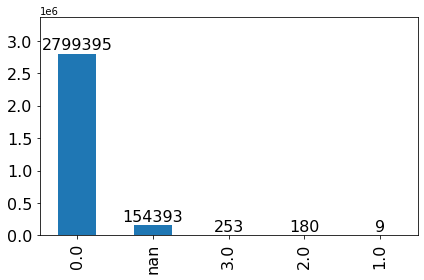

In [19]:
#Check columns that have very few values, e.g. flow_cwr column
ax = df['dTos'].value_counts().plot(kind='bar',fontsize=16) 
for p in ax.patches:
    x = p.get_x()
    h = p.get_height()
    w = p.get_width()
    ax.annotate(f'{h:.0f}\n', (x + w/2, h), ha='center', va='center', size=16)
plt.margins(y=0.2)
plt.tight_layout()
plt.show()

In [20]:
# change label values
df['Label'] = df.Label.str.contains("Botnet")
df['Label'] = df['Label'].astype(int)


In [21]:
#check % class distribution 
y=df['Label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 2948103 of 2954230 (99.8%)
> Class 1 : 6127 of 2954230 (0.2%)


# Codificación de variables categóricas

In [22]:
#Data types for each attibute
df.dtypes

Dur         float64
Proto        object
SrcAddr      object
Sport        object
Dir          object
DstAddr      object
Dport        object
State        object
sTos         object
dTos         object
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label         int32
dtype: object

In [23]:
#Train Test Split
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['Label']), df['Label'], test_size=0.2, random_state=42)

In [24]:
#https://stackoverflow.com/questions/62880686/pipeline-with-and-without-target-based-encoding
from category_encoders import TargetEncoder

In [25]:
# use target encoding to encode five categorical features
enc = TargetEncoder(cols=['Proto','SrcAddr','Sport','Dir','DstAddr','Dport','State','sTos','dTos'])

# transform the datasets
training_numeric_dataset = enc.fit_transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)

In [27]:
#check transformed dataset
training_numeric_dataset

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes
2593109,0.000226,0.000140,0.000000,7.842956e-14,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,321,84
1554536,1.358697,0.010737,0.002078,2.885273e-14,0.009206,0.000000,0.000000,0.003723,0.002103,0.000514,21,1662,957
1311065,0.000644,0.000140,0.002078,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,2,310,64
705633,3062.626221,0.000140,0.000559,1.276470e-08,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,4,268,148
1423647,0.206378,0.010737,0.000000,6.000000e-02,0.009206,0.000000,0.000083,0.003723,0.002103,0.000514,40,30694,1089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,0.000267,0.000140,0.000000,0.000000e+00,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,214,81
2356330,0.000437,0.000140,0.000000,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,2,142,81
2229084,0.309085,0.010737,0.000000,2.222222e-02,0.009206,0.000000,0.000083,0.003723,0.002103,0.000514,32,26439,798
2768307,2163.232666,0.000140,0.002078,9.687389e-18,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,4,659,538


In [28]:
#check transformed dataset
testing_numeric_dataset

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes
2008122,0.000314,0.00014,0.000000e+00,0.000000e+00,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,292,69
2226239,0.003282,0.00014,2.077530e-03,3.469770e-08,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,4,2934,60
2192592,3041.445068,0.00014,2.077530e-03,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,4,272,152
2029061,0.000340,0.00014,6.966998e-07,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,2,235,173
202067,0.000328,0.00014,0.000000e+00,4.613042e-19,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,337,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640412,0.000290,0.00014,0.000000e+00,1.436501e-15,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,264,75
2612957,0.000319,0.00014,0.000000e+00,0.000000e+00,0.000143,0.000055,0.000055,0.000143,0.002103,0.000514,2,296,79
1686459,0.000387,0.00014,2.077530e-03,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,2,128,60
299449,0.000612,0.00014,5.587337e-04,0.000000e+00,0.000143,0.000000,0.000000,0.000143,0.002103,0.000514,2,136,76


In [29]:
#Check that no categorical variables remain
testing_numeric_dataset.dtypes

Dur         float64
Proto       float64
SrcAddr     float64
Sport       float64
Dir         float64
DstAddr     float64
Dport       float64
State       float64
sTos        float64
dTos        float64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
dtype: object

# Estandarización de variables

In [30]:
# Selección de las variables por típo
# https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
from sklearn.preprocessing import StandardScaler

# Se estandarizan las columnas numéricas. Para mantener las columnas a las que 
# no se les aplica # ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()

preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [31]:
X_train_prep = preprocessor.fit_transform(training_numeric_dataset)
X_test_prep  = preprocessor.transform(testing_numeric_dataset)

El resultado devuelto por `ColumnTransformer` es un numpy array, por lo que se pierden los nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe [URL](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html).

In [32]:
#Dimensiones del los datasets de training y testing
X_train_prep.shape, X_test_prep.shape

((2363384, 13), (590846, 13))

# Feature selection
#### Crear X & y para evaluar regresión logística segun listing 16.12 [URL](https://www.w3schools.com/python/numpy/numpy_array_join.asp)

In [33]:
#join the prepared traing and test datasets in a single array X and y
X = np.vstack((X_train_prep, X_test_prep))
y = np.hstack((y_train, y_test))

In [49]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [50]:
type(y), y.dtype

(numpy.ndarray, dtype('int32'))

# Entrenar modelo con algoritmos modificados
## Regresión logística sensible al costo

### LR with hyperparameter: `class_weight='balanced'`
#### Logistic regression with balanced class weights

In [51]:
## split into train test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# weighted logistic regression for class imbalance with heuristic weights

# define model
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=2000)
#model performance
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ROCAUC score: 0.9818423721512376
              precision    recall  f1-score   support

     class 0       1.00      0.96      0.98    589642
     class 1       0.05      1.00      0.10      1204

    accuracy                           0.96    590846
   macro avg       0.53      0.98      0.54    590846
weighted avg       1.00      0.96      0.98    590846



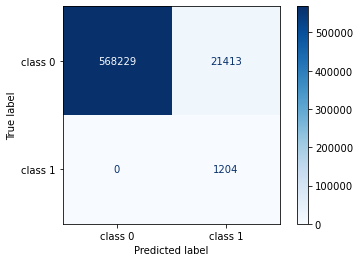

In [53]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
plot_confusion_matrix(model, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

## Modelo con GaussianNB

In [54]:
from sklearn.naive_bayes import *
model2 = GaussianNB()
model2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)

ROCAUC score: 0.5033484335858232
              precision    recall  f1-score   support

     class 0       1.00      0.02      0.04    589642
     class 1       0.00      0.99      0.00      1204

    accuracy                           0.02    590846
   macro avg       0.50      0.50      0.02    590846
weighted avg       1.00      0.02      0.04    590846



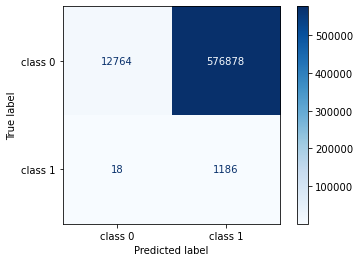

In [55]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

## Weighted Decision Tree with `balanced` hyperparameter

In [56]:
# define model
model_DT_b = DecisionTreeClassifier(class_weight='balanced')
#model performance
model_DT_b.fit(X_train, y_train)
y_pred_DT_b=model_DT_b.predict(X_test)

ROCAUC score: 1.0
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00    589642
     class 1       1.00      1.00      1.00      1204

    accuracy                           1.00    590846
   macro avg       1.00      1.00      1.00    590846
weighted avg       1.00      1.00      1.00    590846



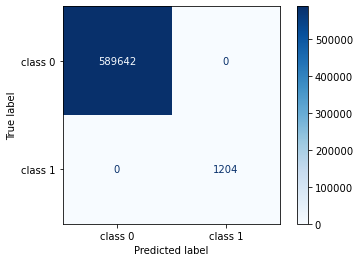

In [57]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred_DT_b))

print(classification_report(y_test, y_pred_DT_b, target_names=target_names))
plot_confusion_matrix(model_DT_b, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

### Weighted SVM

In [ ]:
model_SVM = SVC(class_weight='balanced', probability=True)
model_SVM.fit(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)
y_pred_SVM = model_SVM.predict(X_test)

In [ ]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred_SVM))
print('Accuracy score:',accuracy_score(y_test, y_pred_SVM))
print('F1 score:',f1_score(y_test, y_pred_SVM))
print('Recall score:',recall_score(y_test, y_pred_SVM))
print('Precision score:',precision_score(y_test, y_pred_SVM))

print(classification_report(y_test, y_pred_SVM, target_names=target_names))
plot_confusion_matrix(model_SVM, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

In [ ]:
%reset -f